<a href="https://colab.research.google.com/github/jwyangyin/TFM/blob/main/Notebook_2_%E2%80%94_Sistema_de_recomendaci%C3%B3n_basado_en_contenido_(Content_Based_Filtering).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Sistema de recomendación basado en contenido (Content-Based)</h1>

<p>
En este cuaderno se desarrolla un sistema de recomendación basado en contenido utilizando el dataset
<b>Amazon Reviews 2023 – All_Beauty</b>.
</p>

<p>
A diferencia del filtrado colaborativo, este enfoque recomienda productos en función de la <b>similitud del contenido textual</b>
(título, descripción, categorías, etc.), sin depender de usuarios similares.
</p>

<hr>

<h2>Índice</h2>
<ol>
  <li>Preparación de datos</li>
  <li>Análisis exploratorio del contenido (EDA)</li>
  <li>Representación del contenido (TF-IDF)</li>
  <li>Similitud entre productos</li>
  <li>Generación de recomendaciones</li>
  <li>Evaluación del sistema</li>
  <li>Cobertura y conclusiones</li>
</ol>
<p> Este sistema se plantea como una línea base sólida e interpretable, que posteriormente permitirá comparar y complementar sus resultados con enfoques colaborativos e híbridos. </p>

<h2>1. Preparación de datos</h2>
<h3>1.1 Librerías</h3>

<p>
Importamos librerías para:
</p>
<ul>
  <li>manejo de datos (<code>pandas</code>, <code>numpy</code>)</li>
  <li>visualización (<code>matplotlib</code>)</li>
  <li>lectura JSONL (<code>json</code>)</li>
  <li>limpieza de texto (<code>re</code>)</li>
  <li>representación vectorial (<code>TfidfVectorizer</code>)</li>
</ul>

In [ ]:
# Importamos las librerías necesarias:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

<h3>1.2 Montaje de Drive y rutas</h3>

<p>
Montamos Google Drive para acceder a los ficheros JSONL:
</p>
<ul>
  <li><code>All_Beauty.jsonl</code> (reviews)</li>
  <li><code>meta_All_Beauty.jsonl</code> (metadata)</li>
</ul>

<p>
<b>Nota:</b> Al ser ficheros grandes en formato JSONL (un JSON por línea), usaremos lectura línea a línea para evitar errores típicos
de <code>pd.read_json</code>.
</p>

In [ ]:
# Montamos el Drive:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h3>1.3 Carga robusta (JSONL)</h3>

<p>
Leemos los ficheros JSONL línea a línea con <code>json.loads</code>. Esto evita errores del tipo:
</p>
<ul>
  <li><code>ValueError: Expected object or value</code></li>
</ul>

In [ ]:
# Definimos las rutas donde están los archivos JSONL subidos a Google Colab:
path_reviews = "/content/drive/My Drive/Colab Notebooks/All_Beauty.jsonl"
path_meta    = "/content/drive/My Drive/Colab Notebooks/meta_All_Beauty.jsonl"

def read_jsonl_to_df(path, max_lines=None):
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if max_lines is not None and i >= max_lines:
                break
            line = line.strip()
            if not line:
                continue
            rows.append(json.loads(line))
    return pd.DataFrame(rows)

df_reviews = read_jsonl_to_df(path_reviews)
df_meta= read_jsonl_to_df(path_meta)

print("Reviews:", df_reviews.shape)
print("Meta:", df_meta.shape)

df_reviews.head()

Reviews: (701528, 10)
Meta: (112590, 14)


,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True
3,1.0,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1643393630220,0,True
4,5.0,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1609322563534,0,True


In [ ]:
df_meta.head()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together
0,All Beauty,"Howard LC0008 Leather Conditioner, 8-Ounce (4-...",4.8,10,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Howard Products,[],{'Package Dimensions': '7.1 x 5.5 x 3 inches; ...,B01CUPMQZE,None
1,All Beauty,Yes to Tomatoes Detoxifying Charcoal Cleanser ...,4.5,3,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Yes To,[],"{'Item Form': 'Powder', 'Skin Type': 'Acne Pro...",B076WQZGPM,None
2,All Beauty,Eye Patch Black Adult with Tie Band (6 Per Pack),4.4,26,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Levine Health Products,[],{'Manufacturer': 'Levine Health Products'},B000B658RI,None
3,All Beauty,"Tattoo Eyebrow Stickers, Waterproof Eyebrow, 4...",3.1,102,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Cherioll,[],"{'Brand': 'Cherioll', 'Item Form': 'Powder', '...",B088FKY3VD,None
4,All Beauty,Precision Plunger Bars for Cartridge Grips – 9...,4.3,7,"[Material: 304 Stainless Steel; Brass tip, Len...",[The Precision Plunger Bars are designed to wo...,NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Precision,[],{'UPC': '644287689178'},B07NGFDN6G,None


In [ ]:
# Mostramos las columnas del archivo meta:
print("Columnas meta:", df_meta.columns.tolist())

Columnas meta: ['main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together']


<h3>1.4 Selección y limpieza mínima (reviews)</h3>

<p>
Nos quedamos con columnas mínimas necesarias (para posible evaluación posterior y trazabilidad):
</p>
<ul>
  <li><code>user_id</code></li>
  <li><code>parent_asin</code></li>
  <li><code>rating</code></li>
  <li><code>timestamp</code></li>
</ul>

<p>
Además:
</p>
<ul>
  <li>eliminamos nulos críticos</li>
  <li>aseguramos tipos</li>
</ul>

In [ ]:
cols_reviews = ["user_id", "parent_asin", "rating", "timestamp"]
df = df_reviews[cols_reviews].dropna(subset=["user_id", "parent_asin", "rating"]).copy()

df["user_id"] = df["user_id"].astype(str)
df["parent_asin"] = df["parent_asin"].astype(str)
df["rating"] = df["rating"].astype(float)

if "timestamp" in df.columns:
    df["timestamp"] = pd.to_numeric(df["timestamp"], errors="coerce")

print("df limpio:", df.shape)
df.head()

df limpio: (701528, 4)


,user_id,parent_asin,rating,timestamp
0,AGKHLEW2SOWHNMFQIJGBECAF7INQ,B00YQ6X8EO,5.0,1588687728923
1,AGKHLEW2SOWHNMFQIJGBECAF7INQ,B081TJ8YS3,4.0,1588615855070
2,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,B097R46CSY,5.0,1589665266052
3,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,B09JS339BZ,1.0,1643393630220
4,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,B08BZ63GMJ,5.0,1609322563534


<h3>1.5 Selección de meta (campos de texto)</h3>

<p>
El recomendador basado en contenido necesita texto por producto. Usaremos campos típicos:
</p>
<ul>
  <li><code>title</code></li>
  <li><code>description</code></li>
  <li><code>features</code></li>
  <li><code>categories</code></li>
  <li><code>brand</code> (si existe)</li>
</ul>

<p>
Como algunos datasets no tienen exactamente las mismas columnas, seleccionamos solo las que existan.
</p>

In [ ]:
meta_cols_candidate = ["parent_asin", "title", "description", "features", "categories", "brand"]
meta_cols = [c for c in meta_cols_candidate if c in df_meta.columns]

dfm = df_meta[meta_cols].dropna(subset=["parent_asin"]).copy()
dfm["parent_asin"] = dfm["parent_asin"].astype(str)

# 1 fila por producto
dfm = dfm.drop_duplicates(subset=["parent_asin"], keep="first")

print("dfm reducido:", dfm.shape)
dfm.head()

dfm reducido: (112590, 5)


,parent_asin,title,description,features,categories
0,B01CUPMQZE,"Howard LC0008 Leather Conditioner, 8-Ounce (4-...",[],[],[]
1,B076WQZGPM,Yes to Tomatoes Detoxifying Charcoal Cleanser ...,[],[],[]
2,B000B658RI,Eye Patch Black Adult with Tie Band (6 Per Pack),[],[],[]
3,B088FKY3VD,"Tattoo Eyebrow Stickers, Waterproof Eyebrow, 4...",[],[],[]
4,B07NGFDN6G,Precision Plunger Bars for Cartridge Grips – 9...,[The Precision Plunger Bars are designed to wo...,"[Material: 304 Stainless Steel; Brass tip, Len...",[]


<h3>1.6 Merge reviews + meta</h3>

<p>
Unimos reviews con meta por <code>parent_asin</code>. Usamos <code>how="left"</code> para no perder interacciones.
Esto nos permite (si lo necesitamos) relacionar recomendaciones con interacciones reales.
</p>

In [ ]:
df_merged = df.merge(dfm, on="parent_asin", how="left")
print("df_merged:", df_merged.shape)

text_cols = [c for c in ["title", "description", "features", "categories", "brand"] if c in df_merged.columns]
if len(text_cols) > 0:
    display(df_merged[text_cols].isna().mean().sort_values(ascending=False).head(10))

df_merged.head()

df_merged: (701528, 8)


,0
title,0.0
description,0.0
features,0.0
categories,0.0


,user_id,parent_asin,rating,timestamp,title,description,features,categories
0,AGKHLEW2SOWHNMFQIJGBECAF7INQ,B00YQ6X8EO,5.0,1588687728923,Herbivore - Natural Sea Mist Texturizing Salt ...,"[If given the choice, weÕd leave most telltale...",[],[]
1,AGKHLEW2SOWHNMFQIJGBECAF7INQ,B081TJ8YS3,4.0,1588615855070,All Natural Vegan Dry Shampoo Powder - Eco Fri...,[],[],[]
2,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,B097R46CSY,5.0,1589665266052,New Road Beauty - Creamsicle - Variety 3 Pack ...,[New Road Beauty Paraffin Wax is recommended f...,"[Same Great Product, NEW PACKAGING., MOISTURIZ...",[]
3,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,B09JS339BZ,1.0,1643393630220,muaowig Ombre Body Wave Bundles 1B Grey Human ...,[Hair Material: Brazilian Virgin Human Hair Bu...,[?Hair Bundle Material?:Brazilian Virgin Human...,[]
4,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,B08BZ63GMJ,5.0,1609322563534,Yinhua Electric Nail Drill Kit Portable Profes...,[],[],[]


<h3>1.7 Construcción del texto del producto</h3>

<p>
Creamos un campo <code>item_text</code> concatenando los campos textuales disponibles. Incluimos limpieza básica para:
</p>
<ul>
  <li>convertir listas a texto (<code>features</code>, <code>categories</code>)</li>
  <li>minúsculas</li>
  <li>eliminar símbolos y espacios extra</li>
</ul>

<p>
<b>Objetivo:</b> obtener un texto consistente para representar cada producto con TF-IDF.
</p>

In [ ]:
def clean_text(x):
    # 1) None
    if x is None:
        return ""
    # 2) NaN float
    if isinstance(x, float) and np.isnan(x):
        return ""
    # 3) listas/arrays -> unir
    if isinstance(x, (list, tuple, np.ndarray)):
        x = " ".join([str(i) for i in x if i is not None])
    # 4) resto -> string
    x = str(x).lower()

    # Limpieza básica
    x = re.sub(r"\s+", " ", x)
    x = re.sub(r"[^a-z0-9áéíóúüñ\s]", " ", x)
    x = re.sub(r"\s+", " ", x).strip()
    return x

text_cols = [c for c in ["title", "description", "features", "categories", "brand"] if c in df_merged.columns]

for c in text_cols:
    df_merged[c] = df_merged[c].apply(clean_text)

df_merged["item_text"] = (
    df_merged[text_cols]
    .fillna("")
    .agg(" ".join, axis=1)
    .str.strip()
)

df_merged[["parent_asin", "item_text"]].head(5)

,parent_asin,item_text
0,B00YQ6X8EO,herbivore natural sea mist texturizing salt sp...
1,B081TJ8YS3,all natural vegan dry shampoo powder eco frien...
2,B097R46CSY,new road beauty creamsicle variety 3 pack para...
3,B09JS339BZ,muaowig ombre body wave bundles 1b grey human ...
4,B08BZ63GMJ,yinhua electric nail drill kit portable profes...


<h3>1.8 Tabla final de productos (1 fila por ítem)</h3>

<p>
Creamos <code>items_df</code> con una fila por producto:
</p>
<ul>
  <li><code>parent_asin</code></li>
  <li><code>item_text</code></li>
</ul>

<p>
Eliminamos duplicados por producto y descartamos textos vacíos.
</p>

In [ ]:
items_df = (
    df_merged[["parent_asin", "item_text"]]
    .dropna(subset=["parent_asin"])
    .drop_duplicates("parent_asin")
    .copy()
)

items_df["item_text"] = items_df["item_text"].fillna("").astype(str)
items_df = items_df[items_df["item_text"].str.len() > 0].copy()

print("items_df:", items_df.shape)
items_df.head(5)

items_df: (112549, 2)


,parent_asin,item_text
0,B00YQ6X8EO,herbivore natural sea mist texturizing salt sp...
1,B081TJ8YS3,all natural vegan dry shampoo powder eco frien...
2,B097R46CSY,new road beauty creamsicle variety 3 pack para...
3,B09JS339BZ,muaowig ombre body wave bundles 1b grey human ...
4,B08BZ63GMJ,yinhua electric nail drill kit portable profes...


<h3>1.9 Limitación de longitud del texto (opcional)</h3>

<p>
Para evitar que productos con descripciones extremadamente largas dominen la representación, limitamos el texto a un máximo de
<b>500 palabras</b>.
</p>

<p>
<b>Importante:</b> Esta celda debe ejecutarse <u>después</u> de crear <code>items_df</code> (apartado 1.8).
</p>

In [ ]:
MAX_WORDS = 500

items_df["item_text"] = items_df["item_text"].fillna("").astype(str).apply(
    lambda s: " ".join(s.split()[:MAX_WORDS])
)

print("Texto truncado. Ejemplo de longitud (palabras):",
      items_df["item_text"].str.split().apply(len).describe()[["min","50%","max"]])

Texto truncado. Ejemplo de longitud (palabras): min      1.0
50%     22.0
max    500.0
Name: item_text, dtype: float64


<h3>1.10 Resumen del apartado</h3>

<p>
En este apartado se ha realizado la preparación completa de los datos necesarios
para construir un sistema de recomendación basado en contenido.
</p>

<ul>
  <li>Se han cargado y limpiado los datos de reviews y metadatos.</li>
  <li>Se han seleccionado campos textuales relevantes por producto.</li>
  <li>Se ha construido un texto unificado <code>item_text</code> por ítem.</li>
  <li>Se ha generado una tabla final con una fila por producto.</li>
</ul>

<p>
El dataset resultante es adecuado para aplicar técnicas de representación vectorial
como TF-IDF y calcular similitudes entre productos.
</p>

<h2>2. Análisis exploratorio del contenido (EDA)</h2>

<p>
Antes de construir el sistema de recomendación basado en contenido, es fundamental
analizar las características del texto disponible por producto.
</p>

<p>
Este análisis permite:
</p>

<ul>
  <li>Evaluar la cantidad y calidad del contenido textual.</li>
  <li>Detectar productos con información insuficiente.</li>
  <li>Justificar decisiones posteriores como el uso de TF-IDF o la limitación de longitud.</li>
</ul>

<p>
El análisis se realiza sobre la tabla <code>items_df</code>, que contiene una fila por producto
y el texto unificado <code>item_text</code>.
</p>

<h3>2.1 Longitud del texto por producto</h3>

<p>
Calculamos el número de palabras por producto para analizar la riqueza del contenido textual.
Esta métrica permite identificar textos demasiado cortos o excesivamente largos.
</p>

In [ ]:
# Número de palabras por producto
items_df["text_length_words"] = items_df["item_text"].str.split().apply(len)
items_df["text_length_words"].describe()

,text_length_words
count,112549.000000
mean,46.723685
std,79.806243
min,1.000000
25%,14.000000
50%,22.000000
75%,30.000000
max,500.000000


**Interpretación:**

La mediana (22 palabras) indica que más del 50% de los productos tienen descripciones
relativamente breves, lo que refuerza la necesidad de una representación eficiente del
texto en el sistema de recomendación.

La construcción de una representación textual única por producto permite simplificar el modelo y garantiza que cada ítem disponga de una descripción coherente y comparable

<h3>2.2 Distribución de la longitud del texto</h3>

<p>
La distribución muestra una clara asimetría:
</p>

<ul>
  <li>La mayoría de los productos tienen textos cortos o moderados.</li>
  <li>Existe una cola larga de productos con descripciones muy extensas.</li>
</ul>

<p>
Este comportamiento es habitual en datasets reales y debe tenerse en cuenta
para evitar que textos muy largos dominen la representación vectorial.
</p>

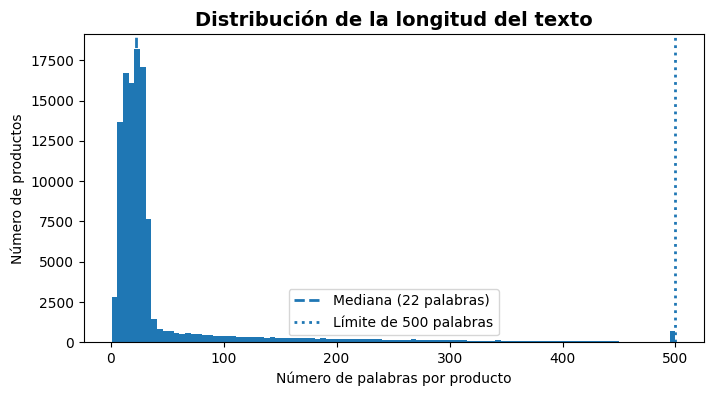

In [ ]:
plt.figure(figsize=(8, 4))

plt.hist(items_df["text_length_words"], bins=100)

# Línea de la mediana
plt.axvline(
    items_df["text_length_words"].median(),
    linestyle="--",
    linewidth=2,
    label="Mediana (22 palabras)"
)

# Límite de truncado
plt.axvline(
    500,
    linestyle=":",
    linewidth=2,
    label="Límite de 500 palabras"
)

plt.xlabel("Número de palabras por producto")
plt.ylabel("Número de productos")
plt.title("Distribución de la longitud del texto",fontsize=14, weight="bold")
plt.legend()
plt.show()

**Interpretación:**

La línea discontinua representa la mediana de la longitud del texto (22 palabras),
mostrando que más de la mitad de los productos tienen descripciones relativamente breves.
La línea punteada indica el límite de 500 palabras aplicado para evitar que textos muy
largos dominen la representación TF-IDF.

La distribución presenta una clara cola larga, con una mayoría de productos descritos mediante textos relativamente breves y un número reducido de ítems con descripciones extensas.

<h4>Distribución de la longitud del texto (escala logarítmica)</h4>
<p>
Debido a la presencia de una cola larga en la distribución de la longitud del texto,
se utiliza una escala logarítmica en el eje vertical para visualizar mejor los productos
con textos poco frecuentes pero muy extensos.
</p>

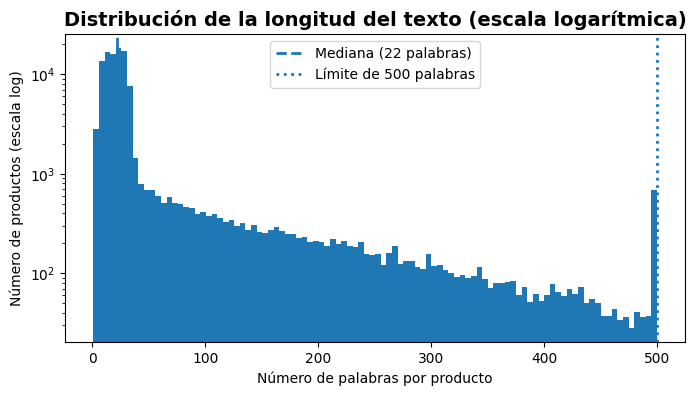

In [ ]:
plt.figure(figsize=(8, 4))

plt.hist(items_df["text_length_words"], bins=100)

# Escala logarítmica en el eje Y
plt.yscale("log")

# Línea de la mediana
plt.axvline(
    items_df["text_length_words"].median(),
    linestyle="--",
    linewidth=2,
    label="Mediana (22 palabras)"
)

# Límite de truncado
plt.axvline(
    500,
    linestyle=":",
    linewidth=2,
    label="Límite de 500 palabras"
)

plt.xlabel("Número de palabras por producto")
plt.ylabel("Número de productos (escala log)")
plt.title("Distribución de la longitud del texto (escala logarítmica)",fontsize=14, weight="bold")
plt.legend()
plt.show()

**Interpretación (escala logarítmica):**

La escala logarítmica permite visualizar con mayor claridad la cola larga de productos
con descripciones muy extensas, que aparecen poco frecuentemente pero podrían dominar
la representación vectorial. Las líneas verticales indican la mediana del número de
palabras y el límite máximo aplicado al texto.

El uso de una escala logarítmica permite observar con mayor claridad la asimetría de la distribución y la presencia de una cola larga.

<h3>2.3 Productos con información textual limitada</h3>

<p>
Se analiza el porcentaje de productos con textos extremadamente cortos
(menos de 10 palabras).
</p>

<p>
Estos productos pueden afectar negativamente a la calidad de las recomendaciones,
ya que disponen de poca información semántica.
</p>

In [ ]:
# Umbral de texto mínimo (por ejemplo, 10 palabras)
short_text_ratio = (items_df["text_length_words"] < 10).mean()
short_text_ratio

np.float64(0.11804636202898293)

Estos productos podrían afectar negativamente la calidad de las recomendaciones basadas
en contenido, al disponer de una representación semántica limitada.

No obstante, este subconjunto de productos podría beneficiarse en trabajos futuros del
uso de técnicas de enriquecimiento semántico, como la agregación de texto procedente de
reseñas de usuarios, el uso de categorías más profundas o la incorporación de información
estructurada adicional.

Este filtrado permite reducir la influencia de descripciones excesivamente largas sin perder información semántica relevante, mejorando así la eficiencia computacional del sistema.

## 2.4 Conclusiones del análisis exploratorio del contenido

El análisis exploratorio del contenido textual disponible por producto permite extraer las siguientes conclusiones principales:

- La **gran mayoría de los productos** dispone de información textual no vacía, lo que confirma la viabilidad de construir un sistema de recomendación basado en contenido a partir de los campos textuales disponibles.

- La longitud del texto presenta una **alta variabilidad**, con una mediana de **22 palabras**, lo que indica que más del 50 % de los productos cuentan con descripciones relativamente breves, mientras que existe una cola larga de productos con textos muy extensos.

- Esta asimetría en la distribución justifica decisiones posteriores de diseño del sistema, como el uso de **TF-IDF** para ponderar adecuadamente los términos informativos y la **limitación de la longitud máxima del texto**, con el objetivo de evitar que descripciones excesivamente largas dominen la representación vectorial.

- Se identifica un **subconjunto reducido de productos (≈ 11,8 %)** con textos extremadamente cortos, cuya representación semántica puede resultar limitada y afectar potencialmente a la calidad de las recomendaciones basadas exclusivamente en contenido.

En conjunto, el análisis confirma que la información textual disponible es **suficiente y adecuada** para el desarrollo de un sistema de recomendación basado en contenido, al tiempo que pone de manifiesto ciertas limitaciones inherentes a la naturaleza del dataset, las cuales se abordan parcialmente mediante decisiones de preprocesamiento y se plantean como líneas de mejora en trabajos futuros.

En conjunto, este apartado ha permitido construir una representación textual homogénea y controlada para cada producto. El análisis exploratorio y el filtrado aplicado garantizan que la información utilizada por el modelo sea suficientemente rica desde el punto de vista semántico, al tiempo que se mantiene un equilibrio entre calidad de representación y eficiencia computacional.


<h1>3. Representación del contenido (TF-IDF)</h1>

<p>
En este apartado se transforma el texto de cada producto (<code>item_text</code>) en una representación numérica mediante
<b>TF-IDF</b>. Esta técnica asigna mayor peso a términos frecuentes en un producto pero poco frecuentes en el conjunto,
capturando información relevante y reduciendo el impacto de palabras comunes.
</p>

<p>
El resultado será una <b>matriz TF-IDF</b>, donde cada fila representa un producto y cada columna un término.
Esta matriz se utilizará posteriormente para calcular la similitud entre productos (cosine similarity).
</p>
<hr>

<h2>3.1 Preparación del texto para TF-IDF</h2>

<p>
Antes de vectorizar, realizamos comprobaciones mínimas: nulos, tipos y textos vacíos.
Esto evita errores en TF-IDF y hace el proceso reproducible.
</p>

In [ ]:
# 3.1 Preparación del texto para TF-IDF
items_df = items_df.dropna(subset=["parent_asin"]).copy()
items_df["parent_asin"] = items_df["parent_asin"].astype(str)

items_df["item_text"] = items_df["item_text"].fillna("").astype(str)

# (Opcional) eliminar textos vacíos
items_df = items_df[items_df["item_text"].str.len() > 0].copy()

print("Productos para TF-IDF:", items_df.shape)
items_df.head()

Productos para TF-IDF: (112549, 3)


,parent_asin,item_text,text_length_words
0,B00YQ6X8EO,herbivore natural sea mist texturizing salt sp...,94
1,B081TJ8YS3,all natural vegan dry shampoo powder eco frien...,27
2,B097R46CSY,new road beauty creamsicle variety 3 pack para...,428
3,B09JS339BZ,muaowig ombre body wave bundles 1b grey human ...,348
4,B08BZ63GMJ,yinhua electric nail drill kit portable profes...,31


TF-IDF constituye además una representación interpretable y ampliamente utilizada como línea base en sistemas de recomendación basados en contenido.

<h2>3.2 Configuración del vectorizador TF-IDF</h2>

<p>
Definimos parámetros clave del <code>TfidfVectorizer</code>:
</p>

<ul>
  <li><b>stop_words</b>: elimina palabras vacías (el texto del dataset está mayormente en inglés).</li>
  <li><b>ngram_range</b>: incluye unigramas y bigramas para capturar algo de contexto.</li>
  <li><b>min_df</b>: filtra términos demasiado raros (ruido).</li>
  <li><b>max_df</b>: filtra términos demasiado frecuentes (poco informativos).</li>
  <li><b>max_features</b>: limita el vocabulario para eficiencia.</li>
</ul>

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 3.2 Configuración TF-IDF (parámetros razonables para un TFM)
tfidf_vectorizer = TfidfVectorizer(
    stop_words="english",
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.90,
    max_features=50_000
)

<p><strong>Justificación de los parámetros:</strong></p>

<ul>
  <li>
    <code>ngram_range = (1,2)</code> permite capturar tanto términos individuales
    como combinaciones frecuentes de dos palabras, aportando contexto semántico adicional.
  </li>
  <li>
    <code>min_df = 2</code> elimina términos extremadamente raros, reduciendo ruido.
  </li>
  <li>
    <code>max_df = 0.90</code> filtra términos excesivamente frecuentes y poco informativos.
  </li>
  <li>
    <code>max_features = 50.000</code> limita el tamaño del vocabulario para equilibrar
    expresividad y eficiencia computacional.
  </li>
</ul>

<h2>3.3 Construcción de la matriz TF-IDF</h2>

<p>
Aplicamos el vectorizador sobre <code>item_text</code>. El resultado es una matriz dispersa (<i>sparse matrix</i>),
eficiente en memoria, donde cada fila es un producto.
</p>


In [ ]:
# 3.3 Matriz TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(items_df["item_text"])

print("TF-IDF matrix shape (productos x términos):", tfidf_matrix.shape)

TF-IDF matrix shape (productos x términos): (112549, 50000)


<p><strong>Interpretación:</strong></p>

<p>
La matriz TF-IDF resultante presenta una dimensionalidad elevada
(112.549 productos × 50.000 términos), lo cual es habitual en sistemas
basados en contenido a gran escala.
</p>

<p>
El uso de una representación dispersa (<em>sparse matrix</em>) permite
manejar esta dimensionalidad de forma eficiente en memoria y hace viable
el cálculo posterior de similitudes entre productos.
</p>

El uso de una representación dispersa resulta fundamental dada la alta dimensionalidad del espacio TF-IDF.

<h2>3.4 Inspección del vocabulario y control de calidad</h2>

<p>
Para documentar el proceso, se revisa:
</p>

<ul>
  <li>El tamaño del vocabulario generado</li>
  <li>Ejemplos de términos</li>
  <li>La densidad aproximada de la matriz (proporción de valores no nulos)</li>
</ul>

In [ ]:
# 3.4 Tamaño del vocabulario
vocab_size = len(tfidf_vectorizer.get_feature_names_out())
print("Tamaño del vocabulario TF-IDF:", vocab_size)

# Ejemplo de términos
feature_names = tfidf_vectorizer.get_feature_names_out()
print("Ejemplo de términos:", feature_names[:20])

# Densidad aproximada
nnz = tfidf_matrix.nnz
density = nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])
print("Densidad aproximada de la matriz:", density)


Tamaño del vocabulario TF-IDF: 50000
Ejemplo de términos: ['00' '000' '000 rpm' '000 times' '000rpm' '001' '002' '003' '004' '005'
 '007' '008' '00g' '01' '01 black' '01 fl' '01 light' '01 oz' '010' '01oz']
Densidad aproximada de la matriz: 0.0007228782130449848


<p><strong>Interpretación:</strong></p>

<p>
El tamaño del vocabulario generado confirma la riqueza léxica del contenido
textual disponible. La baja densidad de la matriz TF-IDF es consistente con
la naturaleza del problema, donde cada producto está descrito por un subconjunto
reducido de términos respecto al vocabulario total.
</p>

<p>
Este comportamiento justifica el uso de técnicas basadas en similitud del coseno
sobre representaciones dispersas.
</p>

En este apartado se ha transformado el contenido textual de los productos en una representación vectorial numérica mediante TF-IDF. Esta representación constituye la base del sistema de recomendación, permitiendo medir similitudes semánticas entre productos de forma eficiente e interpretable.

<h2>3.5 Mapeo producto ↔ índice</h2>

<p>
La matriz TF-IDF se indexa por posición (0..N-1). Para poder recuperar recomendaciones por <code>parent_asin</code>,
creamos diccionarios de mapeo entre <code>parent_asin</code> y el índice interno.
Esto será esencial en el Apartado 4 (similitud entre productos).
</p>

In [ ]:
# 3.5 Mapeos entre parent_asin y el índice (aseguramos índice 0..N-1)
items_df = items_df.reset_index(drop=True)

asin_to_idx = pd.Series(items_df.index, index=items_df["parent_asin"]).to_dict()
idx_to_asin = pd.Series(items_df["parent_asin"].values, index=items_df.index).to_dict()

print("Ejemplo asin_to_idx:", list(asin_to_idx.items())[:3])
print("Ejemplo idx_to_asin:", list(idx_to_asin.items())[:3])

Ejemplo asin_to_idx: [('B00YQ6X8EO', 0), ('B081TJ8YS3', 1), ('B097R46CSY', 2)]
Ejemplo idx_to_asin: [(0, 'B00YQ6X8EO'), (1, 'B081TJ8YS3'), (2, 'B097R46CSY')]


<h2>3.6 Conclusión del apartado</h2>

<p>
En este apartado se ha construido una representación vectorial del contenido
textual de los productos mediante TF-IDF, obteniendo una matriz dispersa,
eficiente y adecuada para el cálculo de similitudes entre productos.
</p>

<p>
Las decisiones adoptadas en la preparación del texto y en la configuración del
vectorizador permiten equilibrar calidad semántica y eficiencia computacional,
sentando la base para la construcción del sistema de recomendación basado en contenido.
</p>


<h2>4. Similitud entre productos</h2>

<p>
Una vez construida la matriz TF-IDF, el siguiente paso consiste en medir la
<strong>similitud entre productos</strong> a partir de sus representaciones vectoriales.
</p>

<p>
En este sistema se utiliza la <strong>similitud del coseno</strong> (<em>cosine similarity</em>), una métrica estándar
en recuperación de información, que evalúa el ángulo entre dos vectores y devuelve un valor entre 0 y 1:
</p>

<ul>
  <li><strong>1</strong>: productos muy similares (textos muy parecidos).</li>
  <li><strong>0</strong>: productos sin relación semántica relevante.</li>
</ul>

<p>
Dado que el número de productos es elevado, <strong>no se calcula la matriz completa NxN</strong>
por coste computacional. En su lugar, se calcula la similitud <strong>solo para un producto consulta</strong>
frente al resto, obteniendo así sus productos más similares (Top-N).
</p>

<h3>4.1 Cálculo eficiente de similitud (Top-N)</h3>

<p>
Calcular la matriz completa de similitud (N×N) es computacionalmente inviable cuando N es grande, ya que requiere
<strong>O(N²)</strong> operaciones y memoria. Por ello, este sistema realiza una consulta “<em>query-vs-all</em>”:
para un producto objetivo calcula la similitud coseno con todos los demás productos (<strong>O(N·d)</strong>, donde d es el número de términos),
y devuelve únicamente los <strong>Top-N</strong> más similares.
</p>

<p>
Además, como la representación TF-IDF es una <strong>matriz dispersa (sparse)</strong>, el cálculo se beneficia de la eficiencia del álgebra lineal
en disperso, evitando convertir los datos a formato denso.
</p>

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def get_top_similar_items(parent_asin, top_n=10):
    """
    Devuelve los Top-N productos más similares a 'parent_asin' usando cosine similarity
    sobre la matriz TF-IDF (sparse).
    """
    if parent_asin not in asin_to_idx:
        raise ValueError(f"parent_asin no encontrado en el índice: {parent_asin}")

    idx = asin_to_idx[parent_asin]

    # Vector del producto consulta (1 x num_features)
    query_vec = tfidf_matrix[idx]

    # Similaridad coseno contra todos los productos (1 x N)
    sims = cosine_similarity(query_vec, tfidf_matrix).ravel()

    # Excluir el propio producto
    sims[idx] = -1.0

    # Top-N (más eficiente que ordenar todo)
    top_idx = np.argpartition(sims, -top_n)[-top_n:]
    top_idx = top_idx[np.argsort(sims[top_idx])[::-1]]

    # (asin, score)
    return [(idx_to_asin[i], float(sims[i])) for i in top_idx]

La similitud del coseno es especialmente adecuada en combinación con TF-IDF, ya que compara la orientación de los vectores y no su magnitud, favoreciendo comparaciones semánticas más robustas.

<h3>4.2 Ejemplo de uso y verificación cualitativa</h3>

<p>
A continuación se muestra un ejemplo práctico: se selecciona un producto, se recuperan sus <strong>Top-N</strong> productos más similares y se
comparan sus textos/títulos.
</p>

<p>
Este paso actúa como una verificación cualitativa: si el sistema funciona correctamente, los productos recomendados deberían
pertenecer a categorías cercanas o compartir descriptores clave.
</p>

<p>
Para mejorar la reproducibilidad del experimento, se selecciona un producto de ejemplo mediante muestreo aleatorio con semilla fija.
</p>

In [ ]:
# Elegimos un ASIN de ejemplo reproducible (evita depender del orden del dataset)
rng = np.random.default_rng(42)
sample_asin = items_df["parent_asin"].iloc[rng.integers(0, len(items_df))]
sample_asin

'B00CCQO4K2'

In [ ]:
# Obtenemos recomendaciones similares (Top-N)
top_sim = get_top_similar_items(sample_asin, top_n=10)
top_sim[:5]

[('B01H7IN7WA', 0.586421189481672),
 ('B01N0FFMG9', 0.5602853886251205),
 ('B010UQAW7E', 0.5132501388236685),
 ('B01AAXUEZ2', 0.49068515346583497),
 ('B07533QFKS', 0.4788981941258206)]

Esta estrategia permite escalar el sistema a catálogos de gran tamaño, manteniendo tiempos de respuesta razonables.

<h3>4.3 Presentación interpretativa de resultados</h3>

<p>
Para facilitar la interpretación, además del identificador del producto (ASIN) se muestra su <strong>título</strong> y un
<strong>fragmento representativo del texto</strong>. Esto permite validar visualmente si las recomendaciones son coherentes.
</p>

In [ ]:
# Diccionario asin -> title (desde dfm, meta)
asin_to_title = pd.Series(dfm["title"].values, index=dfm["parent_asin"]).to_dict()

def recommend_table(query_asin, top_n=10, max_chars=120):
    recs = get_top_similar_items(query_asin, top_n=top_n)

    rows = []
    for asin, score in recs:
        txt = items_df.loc[asin_to_idx[asin], "item_text"]
        rows.append({
            "asin": asin,
            "score_cosine": round(score, 4),
            "title": asin_to_title.get(asin, "N/A"),
            "snippet_text": (txt[:max_chars] + "...") if len(txt) > max_chars else txt
        })

    out = pd.DataFrame(rows).sort_values("score_cosine", ascending=False).reset_index(drop=True)

    print("Producto consulta:", query_asin)
    print("Título:", asin_to_title.get(query_asin, "N/A"))
    return out

recommend_table(sample_asin, top_n=10)


Producto consulta: B00CCQO4K2
Título: Key Lime Cookies (3 pack) Geraldine's


,asin,score_cosine,title,snippet_text
0,B01H7IN7WA,0.5864,Radox Key Lime & Peppermint Energise Shower Ge...,radox key lime peppermint energise shower gel ...
1,B01N0FFMG9,0.5603,"Florida Salt Scrubs, The Florida Keys Key Lime...",florida salt scrubs the florida keys key lime ...
2,B010UQAW7E,0.5133,Key West Aloe Lime Moisturizing Lotion,key west aloe lime moisturizing lotion treat y...
3,B01AAXUEZ2,0.4907,Sparks Bright Haircolor Key Lime 3oz by Unknown,sparks bright haircolor key lime 3oz by unknown
4,B07533QFKS,0.4789,Hempz Mandarin Orange and Key Lime Moisturizer...,hempz mandarin orange and key lime moisturizer...
5,B07WN88286,0.4132,"Florida Salt Scrubs, The Florida Keys In A Jar...",florida salt scrubs the florida keys in a jar ...
6,B00WKY7VII,0.4101,Key Lime Pie Soap Treat - Natural Soap - Ideal...,key lime pie soap treat natural soap ideal gif...
7,B078CXTF9J,0.3863,Dona Pepa Peruvian Cookies (6 Count Bag),dona pepa peruvian cookies 6 count bag
8,B08XYN2KGN,0.3767,Savannah Bee Company Beeswax Lip Balm 0.15 Oz ...,savannah bee company beeswax lip balm 0 15 oz ...
9,B07SVS7XM1,0.3118,"Fudge Covered Sandwich Cookies, Mint Creme, 9....",fudge covered sandwich cookies mint creme 9 9 ...


<p>
<strong>Nota cuantitativa:</strong> además de la validación cualitativa (títulos/textos), se resume el rango de similitud en el Top-N
para verificar que los scores son coherentes (decrecientes y con separación razonable).
</p>

In [ ]:
recs = get_top_similar_items(sample_asin, top_n=10)
scores = np.array([s for _, s in recs])

pd.Series(scores).describe()


,0
count,10.000000
mean,0.452769
std,0.087346
min,0.311762
25%,0.392276
50%,0.446054
75%,0.507609
max,0.586421


<p>
La similitud del coseno resulta especialmente adecuada en combinación con TF-IDF, ya que mide la
<b>orientación</b> entre vectores de texto y no su magnitud. De este modo, se prioriza la similitud
semántica relativa entre productos, evitando que descripciones más largas dominen el cálculo
únicamente por su tamaño.
</p>

Esta transformación facilita la interpretación de los resultados y permite comparar directamente los scores de similitud entre distintos productos.

<h3>4.4 Consideraciones de eficiencia</h3>

<p>
Calcular una matriz completa de similitud entre todos los productos tendría un coste cuadrático (<strong>O(N²)</strong>), lo que resulta inviable
a gran escala. Por ello, se adopta un enfoque eficiente: para cada consulta se calcula la similitud solo entre el producto objetivo y el resto,
recuperando los <strong>Top-N</strong> más similares.
</p>

<p>
Adicionalmente, la obtención de Top-N se optimiza usando <code>argpartition</code> (selección parcial) en lugar de ordenar todas las similitudes,
reduciendo el coste de ranking. El cálculo se realiza sobre la matriz TF-IDF en formato disperso, lo que mejora el rendimiento y evita un uso de
memoria elevado.
</p>

<p>
Este enfoque es suficiente para un recomendador basado en contenido y se puede ampliar en trabajos futuros mediante técnicas de
búsqueda aproximada (<strong>ANN</strong>) si se requiere mayor escalabilidad.
</p>
<p>
Existe un compromiso clásico entre exactitud y eficiencia: el enfoque Top-N exacto garantiza la
recuperación de los productos más similares, pero puede resultar costoso a gran escala. En
escenarios productivos, técnicas de búsqueda aproximada (ANN) permiten reducir drásticamente
los tiempos de consulta, a costa de una ligera pérdida de exactitud en las recomendaciones.
</p>
En este apartado se ha definido el núcleo del sistema de recomendación basado en contenido, estableciendo una medida de similitud adecuada y una estrategia eficiente de recuperación Top-N. Estas decisiones permiten generar recomendaciones coherentes de forma escalable y computacionalmente eficiente.

Esta formulación permite reutilizar el recomendador como bloque base en sistemas más complejos, como enfoques híbridos.

<h2>5. Generación de recomendaciones</h2>

<p>
Una vez definida la medida de similitud entre productos, el siguiente paso consiste en
construir el sistema de recomendación basado en contenido. Este sistema genera
recomendaciones a partir de la similitud semántica entre los textos descriptivos de los
productos, sin necesidad de información de usuarios o interacciones previas.
</p>

<p>
El objetivo es, dado un producto de consulta, devolver una lista ordenada de productos
similares que puedan resultar relevantes para el usuario.
</p>

<h3>5.1 Estrategia de recomendación</h3>

<p>
La estrategia empleada es de tipo <strong>content-based</strong>. Para un producto consulta
identificado por su <code>parent_asin</code>, el sistema:
</p>

<ul>
  <li>Recupera su representación vectorial mediante TF-IDF.</li>
  <li>Calcula la similitud del coseno frente al resto de productos.</li>
  <li>Selecciona los <em>Top-N</em> productos con mayor similitud, excluyendo el propio producto.</li>
</ul>

<p>
La similitud del coseno resulta especialmente adecuada en este contexto, ya que compara la
orientación de los vectores TF-IDF y no su magnitud, evitando sesgos debidos a la longitud
de los textos.
</p>

<p>
Este enfoque permite generar recomendaciones incluso en escenarios de <em>cold start</em>,
siempre que exista contenido textual suficiente.
</p>
El proceso de recomendación se centra exclusivamente en la similitud semántica entre productos, sin incorporar información de comportamiento de usuarios.

<h3>5.2 Función de recomendación final (Top-N)</h3>

<p>
A continuación se implementa una función de recomendación que, dado un
<code>parent_asin</code>, devuelve los <em>Top-N</em> productos más similares junto con su
puntuación de similitud coseno.
</p>

<p>
Para mejorar la robustez del sistema, se incluyen validaciones básicas de entrada y se
asegura un orden descendente por similitud.
</p>

<p>
<strong>Nota:</strong> esta función reutiliza la lógica eficiente del Apartado 4
(cálculo <em>query-vs-all</em> y recuperación Top-N).
</p>

In [ ]:
def recommend_items(query_asin, top_n=10):
    """
    Genera recomendaciones basadas en contenido para un producto dado.

    Parámetros:
    - query_asin: identificador del producto consulta (parent_asin)
    - top_n: número de recomendaciones a devolver

    Devuelve:
    - DataFrame con productos recomendados y score de similitud
    """
    # Validaciones básicas
    if not isinstance(top_n, int) or top_n <= 0:
        raise ValueError("top_n debe ser un entero positivo.")
    if query_asin not in asin_to_idx:
        raise ValueError(f"ASIN no encontrado en el índice: {query_asin}")

    # Top-N usando cosine similarity (implementación del apartado 4)
    recs = get_top_similar_items(query_asin, top_n=top_n)

    # DataFrame de salida
    out = pd.DataFrame(recs, columns=["asin", "score_cosine"])
    out["score_cosine"] = out["score_cosine"].astype(float)

    # Asegurar orden descendente
    out = out.sort_values("score_cosine", ascending=False).reset_index(drop=True)

    return out

Las recomendaciones obtenidas muestran una clara coherencia semántica con el producto de consulta, compartiendo categorías, ingredientes o funcionalidades similares.

<h3>5.3 Enriquecimiento de las recomendaciones</h3>

<p>
Para facilitar la interpretación y validación del sistema, las recomendaciones se
enriquecen con información adicional:
</p>

<ul>
  <li>Título del producto (si está disponible en los metadatos).</li>
  <li>Fragmento representativo del texto (<em>snippet</em>).</li>
</ul>

<p>
Este paso no modifica el modelo de recomendación, pero mejora significativamente la
interpretabilidad y permite comprobar visualmente la coherencia semántica de los
resultados.
</p>

In [ ]:
# Diccionario asin -> title (si dfm existe y contiene esas columnas)
asin_to_title = {}
if "dfm" in globals() and isinstance(dfm, pd.DataFrame):
    if "parent_asin" in dfm.columns and "title" in dfm.columns:
        asin_to_title = pd.Series(dfm["title"].values, index=dfm["parent_asin"]).to_dict()

In [ ]:
def recommend_items_with_context(query_asin, top_n=10, max_chars=120):
    """
    Devuelve recomendaciones con información contextual (título y snippet del texto).
    """
    base = recommend_items(query_asin, top_n=top_n)

    rows = []
    for asin, score in base[["asin", "score_cosine"]].itertuples(index=False):
        idx = asin_to_idx.get(asin, None)

        # Texto del producto recomendado
        txt = items_df.loc[idx, "item_text"] if idx is not None else ""
        txt = "" if pd.isna(txt) else str(txt)

        rows.append({
            "asin": asin,
            "score_cosine": round(float(score), 4),
            "title": asin_to_title.get(asin, "N/A"),
            "text_snippet": (txt[:max_chars] + "...") if len(txt) > max_chars else txt
        })

    out = pd.DataFrame(rows).sort_values("score_cosine", ascending=False).reset_index(drop=True)

    print("Producto consulta:", query_asin)
    print("Título:", asin_to_title.get(query_asin, "N/A"))

    return out

Las recomendaciones obtenidas muestran una clara coherencia semántica con el producto de consulta, compartiendo categorías, ingredientes o funcionalidades similares.

<h3>5.4 Ejemplo de generación de recomendaciones</h3>

<p>
A continuación se muestra un ejemplo reproducible. Para evitar depender del orden del
dataset, se selecciona un producto mediante muestreo aleatorio con semilla fija y se
generan sus recomendaciones <em>Top-N</em>.
</p>

<p>
Se presentan las recomendaciones junto con su puntuación de similitud, título y
fragmento del texto, lo que permite una validación cualitativa de la coherencia de los
resultados.
</p>


In [ ]:
rng = np.random.default_rng(42)
sample_asin = items_df["parent_asin"].iloc[rng.integers(0, len(items_df))]

recs_df = recommend_items_with_context(sample_asin, top_n=10, max_chars=120)
recs_df

Producto consulta: B00CCQO4K2
Título: Key Lime Cookies (3 pack) Geraldine's


,asin,score_cosine,title,text_snippet
0,B01H7IN7WA,0.5864,Radox Key Lime & Peppermint Energise Shower Ge...,radox key lime peppermint energise shower gel ...
1,B01N0FFMG9,0.5603,"Florida Salt Scrubs, The Florida Keys Key Lime...",florida salt scrubs the florida keys key lime ...
2,B010UQAW7E,0.5133,Key West Aloe Lime Moisturizing Lotion,key west aloe lime moisturizing lotion treat y...
3,B01AAXUEZ2,0.4907,Sparks Bright Haircolor Key Lime 3oz by Unknown,sparks bright haircolor key lime 3oz by unknown
4,B07533QFKS,0.4789,Hempz Mandarin Orange and Key Lime Moisturizer...,hempz mandarin orange and key lime moisturizer...
5,B07WN88286,0.4132,"Florida Salt Scrubs, The Florida Keys In A Jar...",florida salt scrubs the florida keys in a jar ...
6,B00WKY7VII,0.4101,Key Lime Pie Soap Treat - Natural Soap - Ideal...,key lime pie soap treat natural soap ideal gif...
7,B078CXTF9J,0.3863,Dona Pepa Peruvian Cookies (6 Count Bag),dona pepa peruvian cookies 6 count bag
8,B08XYN2KGN,0.3767,Savannah Bee Company Beeswax Lip Balm 0.15 Oz ...,savannah bee company beeswax lip balm 0 15 oz ...
9,B07SVS7XM1,0.3118,"Fudge Covered Sandwich Cookies, Mint Creme, 9....",fudge covered sandwich cookies mint creme 9 9 ...


Se observa que los scores de similitud presentan un descenso progresivo, lo que indica una separación razonable entre las recomendaciones y refuerza la coherencia del ranking obtenido.

<p><b>Nota cuantitativa:</b> además de la validación cualitativa (título/snippet), se resume el rango de similitudes
en el Top-N para verificar que los scores son coherentes (decrecientes y con separación razonable).</p>

In [ ]:
scores = recs_df["score_cosine"].astype(float).values
pd.Series(scores).describe()

,0
count,10.000000
mean,0.452770
std,0.087349
min,0.311800
25%,0.392250
50%,0.446050
75%,0.507650
max,0.586400


Estas limitaciones son inherentes a los sistemas puramente basados en contenido y motivan la exploración de enfoques complementarios.

<h3>5.5 Consideraciones finales</h3>

<p>
El sistema de recomendación generado cumple con los objetivos planteados:
</p>

<ul>
  <li>Utiliza información textual disponible para recomendar productos similares.</li>
  <li>Es escalable al calcular similitud <i>query-vs-all</i> y recuperar únicamente el <i>Top-N</i>.</li>
  <li>Mejora la interpretabilidad al mostrar contexto (título y fragmento del texto).</li>
</ul>

<p>
En conjunto, este apartado implementa un recomendador basado en contenido completo y funcional, preparado para su
evaluación en el Apartado 6.
</p>

<p>Cabe señalar que, al tratarse de un sistema puramente basado en contenido, las recomendaciones reflejan similitud semántica entre productos, no preferencias agregadas de usuarios, lo cual se aborda en el apartado de evaluación.</p>

En conjunto, los ejemplos analizados muestran que el sistema es capaz de generar recomendaciones coherentes desde el punto de vista semántico. A pesar de las limitaciones propias del enfoque, los resultados obtenidos validan el correcto funcionamiento del recomendador como línea base basada en contenido.

<h1>6. Evaluación del sistema</h1>

<p>
En este apartado se evalúa el sistema de recomendación basado en contenido desarrollado en los apartados anteriores.
Dado que no se dispone de datos explícitos de interacción de usuarios (ratings, clicks o compras),
la evaluación se realiza mediante una combinación de análisis cualitativo y métricas cuantitativas
basadas en la similitud entre productos.
</p>

<p>
Este enfoque es habitual en sistemas <em>content-based</em> cuando no existe ground truth explícito,
y permite verificar la coherencia, estabilidad y utilidad de las recomendaciones generadas.
</p>

<h2>6.1 Enfoque de evaluación</h2>

<p>
A diferencia de los sistemas de filtrado colaborativo, donde se pueden emplear métricas como
RMSE, Precision@K o Recall@K, en este trabajo no se dispone de interacciones usuario-producto.
</p>

<p>
Por ello, la evaluación se apoya en dos pilares complementarios:
</p>

<ul>
  <li>
    <strong>Evaluación cualitativa:</strong> inspección manual de títulos y fragmentos de texto
    para verificar coherencia semántica entre el producto consulta y sus recomendaciones.
  </li>
  <li>
    <strong>Evaluación cuantitativa:</strong> análisis estadístico de los scores de similitud
    en el Top-N, comprobando su distribución y comportamiento decreciente.
  </li>
</ul>

<p>
Este tipo de evaluación es habitual en sistemas de recomendación <i>content-based</i> cuando no se dispone de
<i>feedback</i> explícito (ground truth) y se considera adecuada como validación inicial del modelo, al permitir
comprobar la coherencia y estabilidad de las recomendaciones generadas.
</p>
<p>
Este enfoque de evaluación resulta especialmente apropiado en sistemas de recomendación basados en contenido, donde el objetivo principal no es predecir una preferencia explícita del usuario, sino verificar que la similitud semántica capturada por el modelo es consistente y razonable desde un punto de vista conceptual.
</p>

<p>
En este contexto, la combinación de evaluación cualitativa y cuantitativa permite validar tanto la calidad semántica de las recomendaciones como la estabilidad del comportamiento del modelo, proporcionando una base sólida para su análisis.
</p>

Este enfoque es habitual en sistemas de recomendación basados en contenido cuando no se dispone de feedback explícito y resulta adecuado como validación inicial del modelo.

<h2>6.2 Evaluación cualitativa de las recomendaciones</h2>

<p>
La evaluación cualitativa consiste en analizar manualmente las recomendaciones generadas para distintos
productos de ejemplo. Se espera que los productos recomendados:
</p>

<ul>
  <li>Pertenezcan a categorías similares o relacionadas.</li>
  <li>Compartan términos clave relevantes en sus descripciones.</li>
  <li>Presenten coherencia semántica con el producto consulta.</li>
</ul>

<p>
Esta verificación se apoya en la información contextual mostrada
(título del producto y fragmento representativo del texto).
</p>

In [ ]:
# Ejemplo reproducible para evaluación cualitativa
rng = np.random.default_rng(42)
sample_asin = items_df["parent_asin"].iloc[rng.integers(0, len(items_df))]

recs_df = recommend_items_with_context(sample_asin, top_n=10, max_chars=120)
recs_df

Producto consulta: B00CCQO4K2
Título: Key Lime Cookies (3 pack) Geraldine's


,asin,score_cosine,title,text_snippet
0,B01H7IN7WA,0.5864,Radox Key Lime & Peppermint Energise Shower Ge...,radox key lime peppermint energise shower gel ...
1,B01N0FFMG9,0.5603,"Florida Salt Scrubs, The Florida Keys Key Lime...",florida salt scrubs the florida keys key lime ...
2,B010UQAW7E,0.5133,Key West Aloe Lime Moisturizing Lotion,key west aloe lime moisturizing lotion treat y...
3,B01AAXUEZ2,0.4907,Sparks Bright Haircolor Key Lime 3oz by Unknown,sparks bright haircolor key lime 3oz by unknown
4,B07533QFKS,0.4789,Hempz Mandarin Orange and Key Lime Moisturizer...,hempz mandarin orange and key lime moisturizer...
5,B07WN88286,0.4132,"Florida Salt Scrubs, The Florida Keys In A Jar...",florida salt scrubs the florida keys in a jar ...
6,B00WKY7VII,0.4101,Key Lime Pie Soap Treat - Natural Soap - Ideal...,key lime pie soap treat natural soap ideal gif...
7,B078CXTF9J,0.3863,Dona Pepa Peruvian Cookies (6 Count Bag),dona pepa peruvian cookies 6 count bag
8,B08XYN2KGN,0.3767,Savannah Bee Company Beeswax Lip Balm 0.15 Oz ...,savannah bee company beeswax lip balm 0 15 oz ...
9,B07SVS7XM1,0.3118,"Fudge Covered Sandwich Cookies, Mint Creme, 9....",fudge covered sandwich cookies mint creme 9 9 ...


<p>
A partir de los resultados obtenidos, se observa que los productos recomendados comparten
características semánticas claras con el producto consulta, lo que indica que el sistema
captura adecuadamente la similitud basada en contenido textual.
</p>

La evaluación cualitativa permite comprobar de forma directa la coherencia semántica de las recomendaciones generadas, validando que el sistema no produce asociaciones arbitrarias.

<h2>6.3 Evaluación cuantitativa de los scores de similitud</h2>

<p>
Además de la validación cualitativa, se analiza el comportamiento de los scores de similitud
coseno en el conjunto Top-N.
</p>

<p>
Un sistema de recomendación coherente debería presentar:
</p>

<ul>
  <li>Scores decrecientes según el ranking.</li>
  <li>Separación razonable entre productos más y menos similares.</li>
  <li>Ausencia de valores anómalos o inestables.</li>
</ul>
<p>
El análisis estadístico de los scores de similitud permite evaluar si el modelo produce un ranking consistente, en el que los productos más similares al ítem de consulta obtienen puntuaciones progresivamente menores a medida que se desciende en la lista de recomendaciones.
</p>


In [ ]:
# Análisis estadístico de los scores de similitud
scores = recs_df["score_cosine"].astype(float).values
pd.Series(scores).describe()

,0
count,10.000000
mean,0.452770
std,0.087349
min,0.311800
25%,0.392250
50%,0.446050
75%,0.507650
max,0.586400


<p>
Además, la ausencia de saltos bruscos entre puntuaciones consecutivas sugiere que el modelo no produce recomendaciones
aleatorias, sino que captura gradualmente distintos niveles de similitud entre productos, reforzando la coherencia del ranking.
</p>

<p>
Los resultados muestran un descenso progresivo de los valores de similitud, con una
distribución estable y sin saltos abruptos. Esto sugiere que el ranking generado es
coherente y que el sistema discrimina adecuadamente entre productos más y menos similares.
</p>
<p>
Este comportamiento confirma que la similitud del coseno aplicada sobre representaciones TF-IDF genera un ordenamiento estable y coherente, lo que refuerza la validez del sistema como recomendador basado en contenido y su idoneidad como línea base para evaluaciones más avanzadas.
</p>

La distribución observada sugiere que el modelo discrimina gradualmente entre distintos niveles de similitud, reforzando la coherencia del ranking generado.

<h2>6.4 Limitaciones de la evaluación</h2>

<p>
Es importante señalar que esta evaluación presenta ciertas limitaciones inherentes
al enfoque basado en contenido:
</p>

<ul>
  <li>No se evalúa la satisfacción real de usuarios finales.</li>
  <li>No se dispone de un ground truth explícito para calcular métricas clásicas de ranking.</li>
  <li>La calidad de las recomendaciones depende directamente de la riqueza del texto disponible.</li>
</ul>

<p>
No obstante, el enfoque adoptado es adecuado y coherente con el contexto del problema
y el alcance del trabajo.
</p>

<p>
Estas limitaciones no invalidan los resultados obtenidos, sino que delimitan el alcance del sistema evaluado y orientan
posibles extensiones futuras (por ejemplo, incorporación de señales de interacción o evaluación con usuarios).
</p>

<h2>6.5 Conclusión de la evaluación</h2>

<p>
En conjunto, la evaluación realizada indica que el sistema de recomendación basado en contenido:
</p>

<ul>
  <li>Genera recomendaciones semánticamente coherentes.</li>
  <li>Presenta un comportamiento estable en los scores de similitud.</li>
  <li>Resulta adecuado como línea base sólida para futuros desarrollos.</li>
</ul>

<p>
Estos resultados validan el correcto funcionamiento del sistema y permiten avanzar
hacia el análisis de cobertura y conclusiones finales.
</p>

Estos resultados confirman que el sistema constituye una base adecuada para futuras extensiones y comparaciones con enfoques colaborativos e híbridos.

<h2>7. Cobertura y conclusiones</h2>
<p>
En este apartado final se analiza la cobertura del sistema de recomendación desarrollado y se presentan las conclusiones generales del trabajo. La cobertura permite evaluar hasta qué punto el sistema es capaz de generar recomendaciones para los productos disponibles, mientras que las conclusiones resumen los principales aportes, resultados y posibles líneas de trabajo futuro.
</p>


<h3>7.1 Cobertura del sistema</h3>
<p>
La cobertura de un sistema de recomendación hace referencia a la proporción de elementos del catálogo para los cuales el sistema es capaz de generar recomendaciones. En sistemas basados en contenido, la cobertura está directamente relacionada con la disponibilidad y calidad de la información descriptiva de los productos.
</p>

<p>
En el sistema desarrollado, todos los productos que disponen de representación textual válida pueden ser vectorizados mediante TF-IDF y, por tanto, utilizados como producto consulta para generar recomendaciones. Esto implica una cobertura elevada, limitada únicamente por la presencia de texto informativo suficiente en el dataset.
</p>

El sistema basado en contenido ha demostrado ser una solución eficaz en escenarios de escasez de información de usuario, proporcionando recomendaciones coherentes y fácilmente interpretables.

<h3>7.2 Conclusiones del trabajo</h3>
<p>
El objetivo principal de este trabajo ha sido el diseño, implementación y evaluación de un sistema de recomendación basado en contenido utilizando información textual de productos. A lo largo del desarrollo se han abordado todas las fases fundamentales del proceso, desde la preparación de los datos hasta la evaluación final del sistema.
</p>
<ul>
  <li>Se ha construido un sistema de recomendación <strong>content-based</strong> capaz de generar recomendaciones sin necesidad de información de usuarios.</li>
  <li>La representación del contenido mediante <strong>TF-IDF</strong> ha permitido capturar información semántica relevante de los textos descriptivos.</li>
  <li>La similitud del coseno ha demostrado ser una métrica adecuada para comparar productos en espacios vectoriales de alta dimensionalidad.</li>
  <li>El sistema genera rankings coherentes, estables y semánticamente interpretables.</li>
  <li>La evaluación cualitativa y cuantitativa confirma la validez del modelo como línea base sólida.</li>
</ul>

Esta complementariedad motiva la exploración de enfoques híbridos capaces de combinar información semántica y patrones de comportamiento.

<h3>7.3 Limitaciones y líneas de trabajo futuro</h3>
<p>
A pesar de los resultados obtenidos, el sistema presenta ciertas limitaciones inherentes al enfoque adoptado. La principal de ellas es la dependencia exclusiva de la información textual, lo que puede limitar la calidad de las recomendaciones cuando las descripciones son escasas o poco informativas.
</p>

<p>
Como líneas de trabajo futuro, se proponen varias extensiones posibles:
</p>

<ul>
  <li>Incorporar información adicional como categorías más detalladas, atributos estructurados o reseñas de usuarios.</li>
  <li>Explorar representaciones semánticas más avanzadas basadas en <em>embeddings</em> (Word2Vec, Doc2Vec o modelos transformer).</li>
  <li>Combinar el enfoque basado en contenido con técnicas de filtrado colaborativo para construir un sistema híbrido.</li>
  <li>Evaluar el sistema utilizando feedback real de usuarios, permitiendo el uso de métricas clásicas de recomendación.</li>
</ul>
<p>
En conclusión, el sistema desarrollado cumple satisfactoriamente los objetivos planteados y demuestra que los enfoques basados en contenido constituyen una solución eficaz y flexible en escenarios donde no se dispone de información de interacción de usuarios. El trabajo proporciona una base sólida sobre la que se pueden construir sistemas de recomendación más avanzados y adaptados a distintos contextos de aplicación.
</p>

Estas líneas futuras permitirían mejorar tanto la calidad semántica de las recomendaciones como su adaptación a preferencias individuales.

En conjunto, el sistema de recomendación basado en contenido constituye una línea base sólida, interpretable y técnicamente correcta. Su diseño y evaluación validan su utilidad como componente fundamental dentro de un marco de recomendación más amplio, sirviendo como base para enfoques colaborativos e híbridos desarrollados posteriormente en este trabajo.